# Água Rasa 2D

Radiational with Fu negative from east

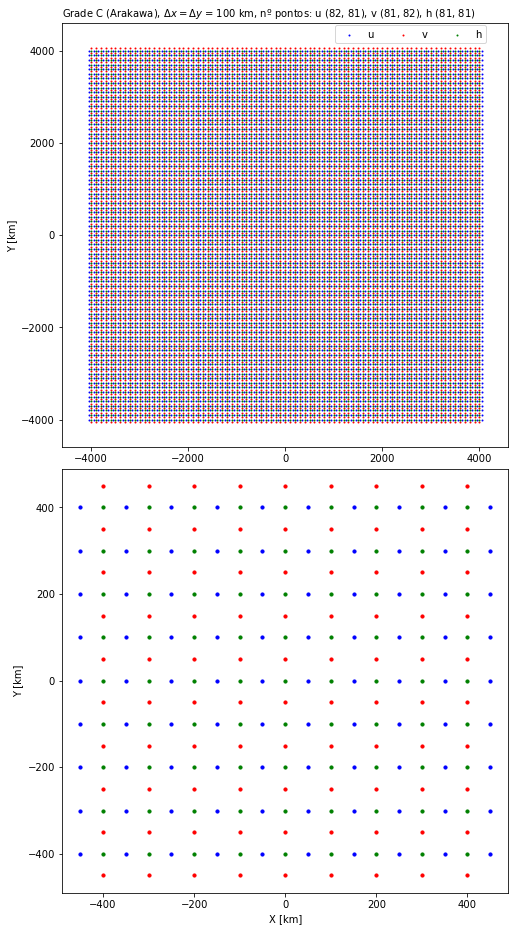

In [25]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio.v2 as imageio
from functions import *
import os

Nx, Ny = 80, 80

# C-grid Arakawa, design
y, yv, Xu, Yu, Xv, Yv, Xh, Yh, dx, dy = plot_gridC(Nx, Ny)

In [26]:
# Conditions
Nt, dt, lat, Nrx, Nry  = 480*24, 100, -20, 10, 4
"""
scen1: f=0
scen2: f at -20 degrees as latitude
scen3: beta variation between -4000 to 4000
"""
cenarios = ['scen1', 'scen2', 'scen3']
rad = True
test = True

# Physics parameters --------------------------------
g = 9.80665         # Gravity acceleration [m/s^2]
H = 250               # Height of the fluid [m]
c = np.sqrt(g*H)    # Velocity phase [m/s]

# Three scenarios
data = {}

if c*dt/dx <= 0.35: 
    for scen in cenarios:
        data[scen] = {'u':{}, 'v':{}, 'h':{}, 'div':{}, 'vor':{}}
        
        u, v, h, Fu, f, beta, div, vor = conditions(scen, Xu, Yu, Xh, Yh, yv, lat,
                                                    Nx, Ny, dx, dy, Nt, Nrx, Nry, test)
        
        u, v, h, div, vor, mass, Ep, Ek = leapfrog(scen, Nt, u, v, h, g, dx, dy, dt,
                                                   H, Fu, f, beta, y, yv, c, div, vor, rad)
        data[scen]['u']   = u
        data[scen]['v']   = v
        data[scen]['h']   = h
        data[scen]['div'] = div
        data[scen]['vor'] = vor
        data[scen]['mass'] = mass
        data[scen]['Ep'] = Ep
        data[scen]['Ek'] = Ek
        
        t_0 = time.perf_counter()  # For timing the computation loop
        print("Computation " + scen + " done!")
else:
    print("Oops! CFL > 0.35. Reduce dt or increase dx, dy")

print("Courant number {:.2f}".format(c*dt/dx))
print("Phase velocity (c): {:.2f}".format(c))


Computation scen1 done!
Computation scen2 done!
Computation scen3 done!
Courant number 0.05
Phase velocity (c): 49.51


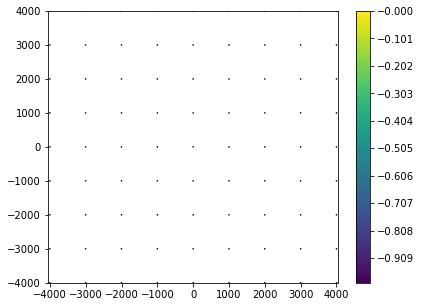

In [3]:
scen='scen1'
# Plots Zonal Source Wind--------------------------------------------------------
fig, ax = plt.subplots(figsize=(6.5,5))
im = ax.contourf(Xu/1000, Yu/1000, Fu[0,:,:]*86400, levels=list(np.linspace(-1,-.00001,100))) #cmap='bwr'
u, v = data[scen]['u'], data[scen]['v']
ax.quiver(Xh[::10, ::10]/1000, Yh[::10, ::10]/1000, u[0, ::10, ::10], v[0, ::10, ::10],
        units = "xy", scale = 0.000000009, width = 50)
fig.colorbar(im, ax=ax, orientation='vertical') # pad, shrink
fig.savefig("fig/fonte_u.png", dpi = 300, bbox_inches='tight', facecolor='w')
# -------------------------------------------------------------------------------

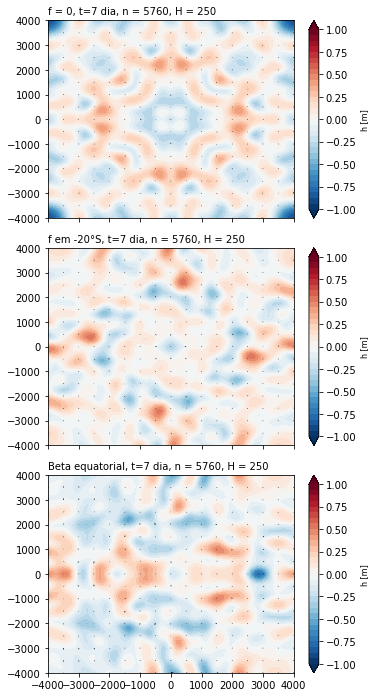

In [27]:
# Arrows
staged_u = np.zeros((Nt+1, Nx+1, Ny+1))
staged_v = np.zeros((Nt+1, Nx+1, Ny+1))

lvs1 = list(np.linspace(-1, 1, 16*2+1))
lvs2 = list(np.linspace(-1, 1, 16*2+1))
lvs3 = list(np.linspace(-1, 1, 16*2+1))
lvs = {'scen1': lvs1, 'scen2':lvs2, 'scen3':lvs3}

arrows = {'scen1': 0.001, 'scen2':0.001, 'scen3':0.001}

n = int(Nt/2)

width = 30
titles = ['f = 0', 'f em -20°S', 'Beta equatorial']
    
fig, axes = plt.subplots(3,1, figsize=(5.5,12), sharex=True, sharey=True, gridspec_kw={'wspace':0.15, 'hspace':0.15} )
for ax, scen, tit in zip(axes.flatten(), cenarios, titles):
    im = ax.contourf(Xh/1000, Yh/1000, data[scen]['h'][n,:,:], cmap=plt.cm.RdBu_r, levels=lvs[scen], extend='both')
    cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_ylabel('h [m]', fontsize=8)
    u, v = data[scen]['u'], data[scen]['v']
    staged_u[:, :, :] = (u[:, 1:, :] + u[:, :-1, :]) * 0.5
    staged_v[:, :, :] = (v[:, :, 1:] + v[:, :, :-1]) * 0.5
    Q = ax.quiver(Xh[::5, ::5]/1000, Yh[::5, ::5]/1000, staged_u[n, ::5, ::5], staged_v[n, ::5, ::5],
        units = "xy", scale = arrows[scen], width = width)
    #ax.quiver(-3000,3000,1,0,scale=20,width=width)
    ax.set_xlim(-4000, 4000)
    ax.set_ylim(-4000, 4000)
    #qk = ax.quiverkey(Q, 0.9, 0.8, 1000, "0.1 m/s", labelpos = "E", coordinates = "figure")
    ax.set_title(tit+", t={:.0f} dia, n = {:.0f}, H = {:.0f}".format(dt*n/(3600*24), n, H), fontsize=10, loc='left')
#cax = fig.add_axes([.05,.07,0.9,.02]) # left, bottom, width, height
#cbar = fig.colorbar(im, cax=cax, orientation='horizontal') # pad, shrink
#cbar.ax.tick_params(labelsize=9)
fig.savefig("fig/leapfrog_"+str(H)+"m_cenarios.png", dpi = 300, bbox_inches='tight', facecolor='w')


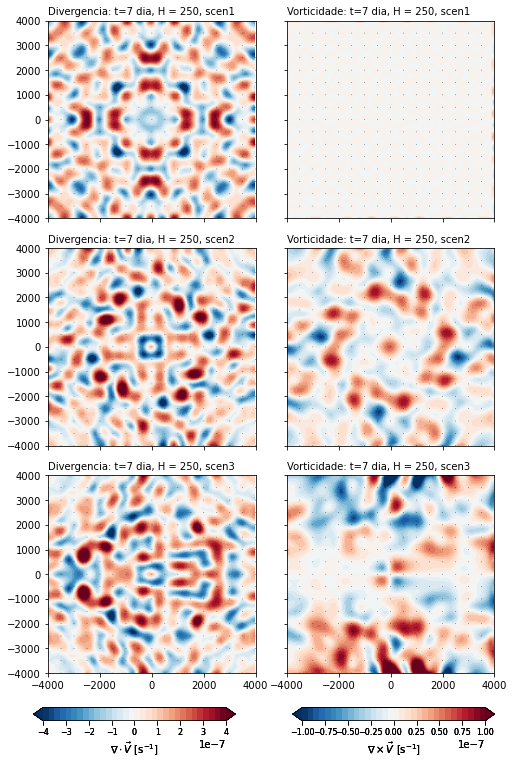

In [28]:
# Divergence & Vorticity
# ----------------------
staged_u = np.zeros((Nt+1, Nx+1, Ny+1))
staged_v = np.zeros((Nt+1, Nx+1, Ny+1))

lvs1 = list(np.linspace(-.0000004,.0000004,2*16+1))
lvs2 = list(np.linspace(-.0000001,.0000001,2*16+1))
n = int(Nt/2)
titles = ['f = 0', 'f em -20°S', 'Beta equatorial']
arrows2 = {'scen1': 0.05, 'scen2': 0.003, 'scen3':0.005}
    
fig, axes = plt.subplots(3,2, figsize=(8,12), sharex=True, sharey=True, gridspec_kw={'wspace':0.15, 'hspace':0.15} )
# Divergencia
# -----------
for ax, scen in zip([axes[0,0], axes[1,0], axes[2,0]], cenarios):
    im = ax.contourf(Xu[:-1,:]/1000,Yu[:-1,:]/1000, data[scen]['div'][n,:,:], levels=lvs1, cmap=plt.cm.RdBu_r,  extend='both') #,
    #cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    # u, v = data[scen]['u'], data[scen]['v']
    # staged_u[:, :, :] = (u[:, 1:, :] + u[:, :-1, :]) * 0.5
    # staged_v[:, :, :] = (v[:, :, 1:] + v[:, :, :-1]) * 0.5
    Q = ax.quiver(Xh[::5, ::5]/1000, Yh[::5, ::5]/1000, 
                  data[scen]['u'][n,::5, ::5], data[scen]['v'][n,::5, ::5],
                  units = "xy", scale = arrows2[scen])
    #qk = ax.quiverkey(Q, 0.9, 0.8, 1000, "0.1 m/s", labelpos = "E", coordinates = "figure")
    ax.set_xlim(-4000, 4000)
    ax.set_ylim(-4000, 4000)
    ax.set_title("Divergencia: t={:.0f} dia, H = {:.0f}, ".format(dt*n/(3600*24),  H)+scen, fontsize=10, loc='left')
    cax = fig.add_axes([.1,.07,0.35,.015]) # left, bottom, width, height
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal') # pad, shrink
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.set_xlabel('$\\nabla \\cdot \\vec{V}$'+' [s$^{-1}$]')
    
# Vorticidade
# -----------
for ax, scen in zip([axes[0,1], axes[1,1], axes[2,1]], cenarios):
    im = ax.contourf(Xu[:-1,:]/1000,Yu[:-1,:]/1000, data[scen]['vor'][n,:,:], levels=lvs2, cmap=plt.cm.RdBu_r,  extend='both') #levels=lvs,
    #cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    # u, v = data[scen]['u'], data[scen]['v']
    # staged_u[:, :, :] = (u[:, 1:, :] + u[:, :-1, :]) * 0.5
    # staged_v[:, :, :] = (v[:, :, 1:] + v[:, :, :-1]) * 0.5
    Q = ax.quiver(Xh[::5, ::5]/1000, Yh[::5, ::5]/1000, 
                  data[scen]['u'][n,::5, ::5], data[scen]['v'][n,::5, ::5],
                  units = "xy", scale = arrows2[scen])
    #qk = ax.quiverkey(Q, 0.9, 0.8, 1000, "0.1 m/s", labelpos = "E", coordinates = "figure")
    ax.set_xlim(-4000, 4000)
    ax.set_ylim(-4000, 4000)
    ax.set_title("Vorticidade: t={:.0f} dia, H = {:.0f}, ".format(dt*n/(3600*24),  H)+scen, fontsize=10, loc='left')
    cax = fig.add_axes([.55,.07,0.35,.015]) # left, bottom, width, height
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal') # pad, shrink
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.set_xlabel('$\\nabla \\times \\vec{V}$'+' [s$^{-1}$]')

fig.savefig("fig/leapfrog_div_vor"+str(H)+"m_"+scen+".png", dpi = 300, bbox_inches='tight', facecolor='w')


[ 1.          1.00107069  1.00214139 ... 13.33119194 13.33226264
 13.33333333]


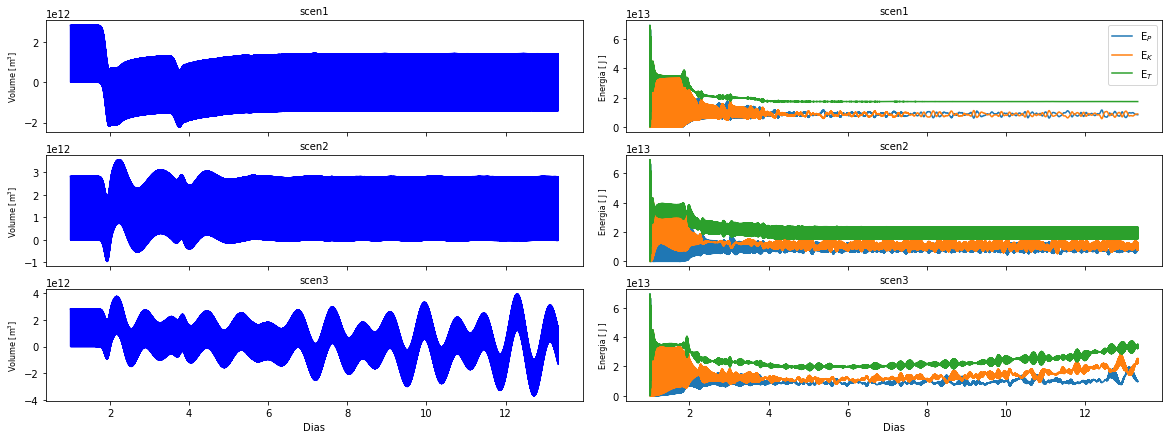

In [29]:
t = np.linspace(1, Nt*dt/(24*3600), Nt)
print(t)
fig, axes = plt.subplots(3, 2, figsize=(20, 7), sharex=True,
                         gridspec_kw={'wspace':0.08})

# Massa
for ax, scen in zip([axes[0,0], axes[1,0], axes[2,0]], cenarios):
    ax.plot(t, data[scen]['mass'][:-1], c='b')
    ax.set_title(scen, fontsize=10, loc='center')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
    ax.set_ylabel("Volume [m$^3$]", fontsize=8)

axes[2,0].set_xlabel('Dias')
    
# Energia
for ax, scen in zip([axes[0,1], axes[1,1], axes[2,1]], cenarios):
    Ep, Ek = data[scen]['Ep'][:-1], data[scen]['Ek'][:-1]
    Et = Ep + Ek
    ax.plot(t, Ep, label='E$_P$')
    ax.plot(t, Ek, label='E$_K$')
    ax.plot(t, Et, label='E$_T$')
    ax.set_title(scen, fontsize=10, loc='center')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_ylabel("Energia [ J ]", fontsize=8)

axes[2,1].set_xlabel('Dias')
axes[0,1].legend()
fig.savefig("fig/leapfrog_vol_ener"+str(H)+"m_.png", dpi = 300, bbox_inches='tight', facecolor='w')


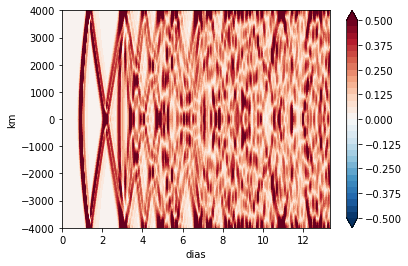

In [30]:
# Hovmoller
t, _ = np.linspace(0, (Nt)*dt, Nt+1, retstep = True)

Y, T = np.meshgrid(y, t)

colores = ['c','snow','w','bisque', 'peachpuff','orange', 'r', 'brown','k']
lvs1 = list(np.linspace(-.5, .5, 16*2+1))

C_s = data['scen1']['h'][:, 0, :]
fig, ax = plt.subplots(1,figsize=(6,4))
im = ax.contourf(T/(24*3600), Y/1000, C_s, lvs1, origin='lower', cmap=plt.cm.RdBu_r, extend='both')
#im.cmap.set_under('w')
#im.cmap.set_over('k')
ax.set_ylabel("km")
ax.set_xlabel("dias")
# if filtro == True:
#     ax.set_title(f"Diagrama Hovmoller, \n filtro (gamma={gamma}, alfa={alfa})", loc='left')
# else:
#     ax.set_title(f"Diagrama Hovmoller", loc='left')
cbar = fig.colorbar(im, ax=ax, orientation="vertical") #fraction=0.04, pad=0.08
# cbar.ax.set_title(ylabel[0], fontsize=8)

fig.savefig("fig/hovmoller_x0j_f0.png", 
             dpi = 400, bbox_inches='tight', facecolor='w')

In [31]:
# plot the line chart
for scen in cenarios:
    
    filenames = []

    for n in range(1, Nt, 24):
        fig, ax = plt.subplots()
        im = ax.contourf(Xh/1000, Yh/1000, 
                        data[scen]['h'][n,:,:], 
                        cmap = plt.cm.RdBu_r, 
                        levels = lvs[scen], extend='both')
        
        fig.colorbar(im, ax=ax, orientation="vertical")
        ax.set_title("t={:.0f} dias, passo de tempo = {:.0f}".format(dt*n/(24*3600), n), 
                     fontsize=10, loc='left')
        ax.set_xlim(-4000, 4000)
        ax.set_ylim(-4000, 4000)
        
        Q = ax.quiver(Xh[::5, ::5]/1000, Yh[::5, ::5]/1000,
                      data[scen]['u'][n,::5, ::5], data[scen]['v'][n,::5, ::5],
                      units = "xy", scale = arrows[scen], width = 20)

        # create file name and append it to a list
        filename = f'fig/gifs/{n}.png'
        filenames.append(filename)

        # save frame
        fig.savefig(filename, dpi=200)
        plt.close() # build gif

    if test == True:
        
        with imageio.get_writer('gifs/leap_'+str(H)+'m_'+scen+'_Fh.gif', mode='I', duration = .10) as writer:
            for filename in filenames:
                image = imageio.imread(filename)
                writer.append_data(image)

    else:
        with imageio.get_writer('gifs/leap_'+str(H)+'m_'+scen+'_Fu_negativo.gif', mode='I', duration = .10) as writer:
            for filename in filenames:
                image = imageio.imread(filename)
                writer.append_data(image)
    # Remove files
    for filename in set(filenames):
        os.remove(filename) 
    print(scen) 

scen1
scen2
scen3
